In [1]:
import meep as mp
import meep.adjoint as mpa
import numpy as np
from autograd import numpy as npa
from autograd import tensor_jacobian_product, grad
import nlopt
from matplotlib import pyplot as plt
from matplotlib.patches import Circle
import math

from meep.materials import Ag

In [2]:
fontlabel = 16

lambda_min = 0.4       # 최소 파장 (µm)
lambda_max = 0.7       # 최대 파장 (µm)
fmin = 1/lambda_max    # 최소 주파수
fmax = 1/lambda_min    # 최대 주파수
fcen = 0.5*(fmin+fmax) # 중앙 주파수
df = fmax-fmin         # 주파수 대역폭

resolution = 50        # 시뮬레이션 해상도
nfreq = 1             # 추출할 주파수 개수
design_region_resolution = 50

In [3]:
tag_bot         = 0.5
tag_side        = 4
tsio2           = 4
monitor_position =  1 / fcen * 2
monitor_blank   = 1 / fcen * 0.1

tpml = 0.4

width_ag = 0.2
width_sio2 = 2

width_bot_ag = width_ag+width_sio2+width_ag

design_region_width = round(width_bot_ag, 3)
design_region_height = 0.5

Sx = tpml+width_bot_ag+tpml
Sy = round(tag_bot+tag_side+design_region_height+monitor_position+monitor_blank+tpml, 1)

SiO2 = mp.Medium(index = 1.45)
TiO2 = mp.Medium(index = 2.6)

Nx = int(design_region_resolution * design_region_width) + 1
# Ny = int(design_region_resolution * design_region_height) + 1
Ny = 1

y_bottom = -Sy/2
center_y_ag = y_bottom + tag_bot / 2
center_y_sio2 = y_bottom + tag_bot + tsio2 / 2
center_y_design = y_bottom + tag_bot + tsio2 + design_region_height / 2
center_y_monitor_position = y_bottom + tag_bot + tsio2 + design_region_height + monitor_position
center_y_source_position = y_bottom + tag_bot + 1/fcen 
center_Ag_x_position = design_region_width/2-width_ag/2 #+ tpml/2

design_variables = mp.MaterialGrid(mp.Vector3(Nx, Ny), TiO2, SiO2,  grid_type="U_MEAN")

boundary_layers = [mp.Absorber(tpml,direction=mp.X),
                   mp.PML(tpml,direction=mp.Y,side=mp.High)]

In [4]:
# 셀 크기 설정
cell_size = mp.Vector3(Sx, Sy)

# 기본 지오메트리 정의
geometry = [
    # Bottom Ag layer
    mp.Block(
        material=Ag,
        size=mp.Vector3(width_bot_ag, tag_bot, 0),
        center=mp.Vector3(0, center_y_ag, 0)
    ),
    # SiO2 layer
    mp.Block(
        material=SiO2,
        size=mp.Vector3(width_sio2, tsio2, 0),
        center=mp.Vector3(0, center_y_sio2, 0)
    ),
    # Side metal
    mp.Block(
        material=Ag,
        size=mp.Vector3(width_ag, tsio2, 0),
        center=mp.Vector3(-center_Ag_x_position, center_y_sio2, 0)
    ),
    mp.Block(
        material=Ag,
        size=mp.Vector3(width_ag, tsio2, 0),
        center=mp.Vector3(center_Ag_x_position, center_y_sio2, 0)
    ),
]


In [5]:
# 몇개의 layer로 최적화를 할건지 설정하고 싶다면 layer_num 갯수 조절
layer_num = 1

ML = (layer_num > 1)

region_height_each = design_region_height / layer_num
full_center_y = y_bottom + tag_bot + tsio2 + design_region_height/2

if ML:
    design_variables = []
    design_region = []
    for dv in range(layer_num):
        mg = mp.MaterialGrid(
            mp.Vector3(Nx, Ny),
            TiO2,       
            SiO2,       
            grid_type="U_MEAN",
            do_averaging=False
        )
        design_variables.append(mg)
        offset = ((layer_num - 1) / 2 - dv) * region_height_each
        center_y = full_center_y + offset

        dr = mpa.DesignRegion(
            mg,
            volume=mp.Volume(
                center=mp.Vector3(0, center_y, 0),
                size=mp.Vector3(design_region_width, region_height_each, 0),
            ),
        )
        design_region.append(dr)

        geometry.append(
            mp.Block(
                material=design_variables[dv],
                size=design_region[dv].size,
                center=design_region[dv].center
            )
        )
else:
    design_variables = mp.MaterialGrid(
        mp.Vector3(Nx, Ny),
        TiO2,
        SiO2,
        grid_type="U_MEAN",
        do_averaging=False
    )
    design_region = mpa.DesignRegion(
        design_variables,
        volume=mp.Volume(
            center=mp.Vector3(0, full_center_y, 0),
            size=mp.Vector3(design_region_width, region_height_each, 0),
        )
    )
    geometry.append(
        mp.Block(
            material=design_variables,
            size=design_region.size,
            center=design_region.center
        )
    )


In [6]:
src = mp.GaussianSource(frequency=fcen, fwidth=df, is_integrated=True)

sources = mp.Source(
            src,
            component=mp.Ez,
            center=mp.Vector3(
                0,
                center_y_source_position,  # Alq3 층의 중간 높이
                0
            )
        )

sim = mp.Simulation(
    resolution=resolution,
    sources=[sources],
    cell_size=cell_size,
    boundary_layers=boundary_layers,
    geometry=geometry,
    default_material=mp.Medium(index = 1),
    extra_materials=[Ag]
)

     block, center = (0,-3,0)
          size (2.4,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     

block, center = (0,-0.75,0)
          size (2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (-1.1,-0.75,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (1.1,-0.75,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,1.5,0)
          size (2.4,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)


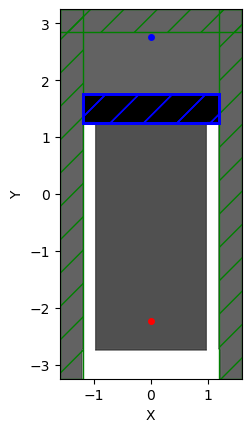

In [7]:
monitor_position_J, monitor_size = mp.Vector3(0, center_y_monitor_position), mp.Vector3(0,0)
FourierFields = mpa.FourierFields(sim,mp.Volume(center=monitor_position_J,size=monitor_size),mp.Ez,yee_grid=True)
ob_list = [FourierFields]

def J(fields):
    return npa.mean(npa.real(fields) ** 2) # The index 1 corresponds to the point at the center of our monitor.

opt = mpa.OptimizationProblem(
            simulation=sim,
            objective_functions=[J],
            objective_arguments=ob_list,
            design_regions=design_region,        # 한 개의 DesignRegion
            frequencies=[fcen],
            maximum_run_time=300,
        )

opt.plot2D(True)

In [8]:
class AdamOptimizer:
    def __init__(self, lr=0.01, beta1=0.9, beta2=0.999, epsilon=1e-8, warmup_iters=10):
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.mt = None
        self.vt = None
        self.iter = 0
        self.warmup_iters = warmup_iters
    
    def update(self, v, gradient):
        if self.mt is None:
            self.mt = np.zeros_like(v)
        if self.vt is None:
            self.vt = np.zeros_like(v)
            
        #Adam에서는 기울기 값과 기울기의 제곱값의 지수이동평균을 활용하여 step 변회량을 조절
        self.iter += 1
        self.mt = self.beta1 * self.mt + (1 - self.beta1) * gradient           #m_(t)=beta_(1)*m_(t-1)+(1-beta_(1))*gradient
        self.vt = self.beta2 * self.vt + (1 - self.beta2) * (gradient ** 2)       #v_(t)=beta_(2)*v_(t-1)+(1-beta_(2))*(gradeint^2)
         
        # 초기 몇번의 update에서 0으로 편향되어 있어서 출발 지점에서 멀리 떨어진 곳으로 이동하는, 초기 경로의 편향 문제를 해결 하기 위해 unbiased하게 만들어줌
        m_hat = self.mt / (1 - self.beta1 ** self.iter)   #m_hat=m/(1-beta1**t)
        v_hat = self.vt / (1 - self.beta2 ** self.iter)
        
        # Warm-up 단계
        if self.iter <= self.warmup_iters:
            warmup_factor = self.iter / self.warmup_iters
            lr = self.lr * warmup_factor
        else:
            lr = self.lr   #lr_t <- alpha*sqrt
            
        #update = self.lr * m_hat / (np.sqrt(v_hat) + self.epsilon)
        update_factor= m_hat / (np.sqrt(v_hat) + self.epsilon) #theta_t <- theta_(t-1)-alpha_(t)*m_(t)/(sqrt(v_(t))+epsilon) alpha_(t)=learning rate
        update = lr * update_factor
        updated_v = v + update
        updated_v = np.clip(updated_v, 0.0, 1.0)
        
        adam_lr=np.mean(np.abs(update))
        adam_uf=np.mean(np.abs(update_factor))
        
        # adam_beta1=self.beta1
        # # adam_beta2=self.beta2
        adam_m=self.mt
        adam_v=self.vt
        adam_t=self.iter
        
        return updated_v, adam_lr, adam_uf, adam_m, adam_v, adam_t

In [13]:
eta_i = 0.5

def multi_mapping(x, eta, beta):    
    size_each = Nx * Ny

    v3 = x.reshape(layer_num, size_each)

    rho_list = []
    for i in range(layer_num):
        layer_field = v3[i].reshape(Nx, Ny)
        sym_field   = (layer_field[::-1, :] + layer_field) / 2
        flat        = sym_field.ravel()
        proj        = mpa.tanh_projection(flat, beta, eta)
        rho_list.append(proj)

    return npa.concatenate(rho_list, axis=0)



--- Iter 1 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2
Current FOM: 0.05188474428699945
Binary degree : 0.08938635267262965 


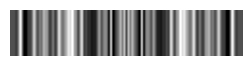


--- Iter 2 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2
Current FOM: 0.054770929908691514
Binary degree : 0.09026662586849753 


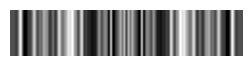


--- Iter 3 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2
Current FOM: 0.06040417071100614
Binary degree : 0.09292218514614325 


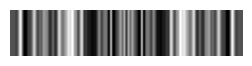


--- Iter 4 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2
Current FOM: 0.06840495112745272
Binary degree : 0.09784632264634986 


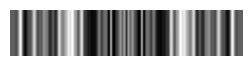


--- Iter 5 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2
Current FOM: 0.07784082306743739
Binary degree : 0.1058136794556859 


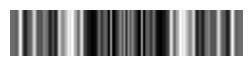


--- Iter 6 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2
Current FOM: 0.08894842208349286
Binary degree : 0.11661127688531849 


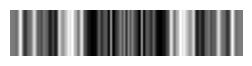


--- Iter 7 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2
Current FOM: 0.10273117042637354
Binary degree : 0.13029491028417495 


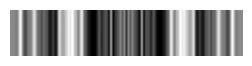


--- Iter 8 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2
Current FOM: 0.11662977807707445
Binary degree : 0.1472728642957782 


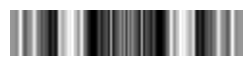


--- Iter 9 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2
Current FOM: 0.13170864859053116
Binary degree : 0.17073043499379442 


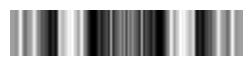


--- Iter 10 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2
Current FOM: 0.15147709913161508
Binary degree : 0.20039729935032663 


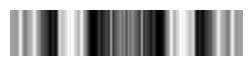


--- Iter 11 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2
Current FOM: 0.17189156030159136
Binary degree : 0.2330445812418819 


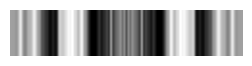


--- Iter 12 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2
Current FOM: 0.19230830018866762
Binary degree : 0.2614165136174701 


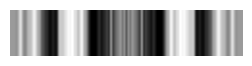


--- Iter 13 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2
Current FOM: 0.2208736881148269
Binary degree : 0.28556028719062365 


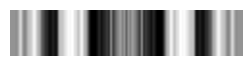


--- Iter 14 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2
Current FOM: 0.2671664764734733
Binary degree : 0.3055408724529822 


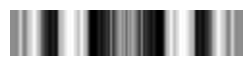


--- Iter 15 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2
Current FOM: 0.3244282866063196
Binary degree : 0.32280265247289985 


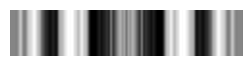


--- Iter 16 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2
Current FOM: 0.37108948596121377
Binary degree : 0.33796223827238725 


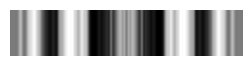


--- Iter 17 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2
Current FOM: 0.41848704452479213
Binary degree : 0.3521635228061315 


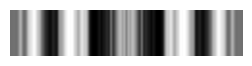


--- Iter 18 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2
Current FOM: 0.4539385735611568
Binary degree : 0.3676990287646876 


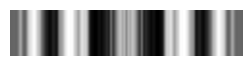


--- Iter 19 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2
Current FOM: 0.5258985519059698
Binary degree : 0.38405848206840426 


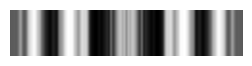


--- Iter 20 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2
Current FOM: 0.585699010174745
Binary degree : 0.40112933731948724 


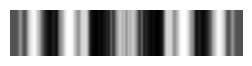


--- Iter 21 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2
Current FOM: 0.5716538268164718
Binary degree : 0.4131382353314274 


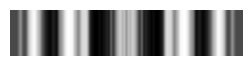


--- Iter 22 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2
Current FOM: 0.6652079277513713
Binary degree : 0.4250170906029409 


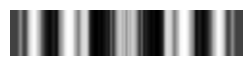


--- Iter 23 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2
Current FOM: 0.5510990811478428
Binary degree : 0.4379891384031546 


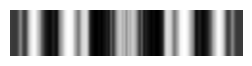


--- Iter 24 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2
Current FOM: 0.6403983606670306
Binary degree : 0.44470375817355595 


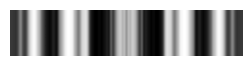


--- Iter 25 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2
Current FOM: 0.5246892821521535
Binary degree : 0.45194010148519964 


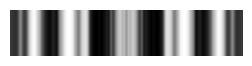


--- Iter 26 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2
Current FOM: 0.5929827159212352
Binary degree : 0.4593014667546456 


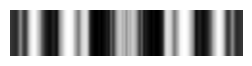


--- Iter 27 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2
Current FOM: 0.7752002391252452
Binary degree : 0.4666806475142697 


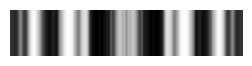


--- Iter 28 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2
Current FOM: 0.6417752556207033
Binary degree : 0.4739355869628324 


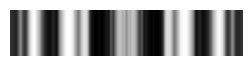


--- Iter 29 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2
Current FOM: 0.7755955076898161
Binary degree : 0.47921452745234683 


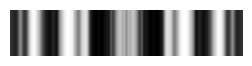


--- Iter 30 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2
Current FOM: 0.7213996634702408
Binary degree : 0.48395723133851215 


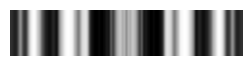


--- Iter 31 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2
Current FOM: 0.6421394097444987
Binary degree : 0.48867903422227216 


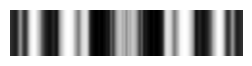


--- Iter 32 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2
Current FOM: 0.6943842141242104
Binary degree : 0.49321931037927647 


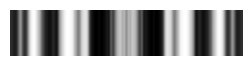


--- Iter 33 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2
Current FOM: 0.8156995151654355
Binary degree : 0.49774997302070023 


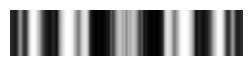


--- Iter 34 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2
Current FOM: 0.7427725275628527
Binary degree : 0.502039930024841 


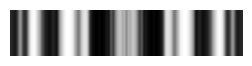


--- Iter 35 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2
Current FOM: 0.8369669051454807
Binary degree : 0.5051729816681277 


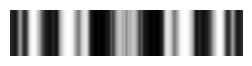


--- Iter 36 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2
Current FOM: 0.7985486491989515
Binary degree : 0.5077613635314432 


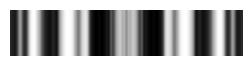


--- Iter 37 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2
Current FOM: 0.7704026297641616
Binary degree : 0.5105129660107662 


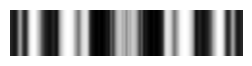


--- Iter 38 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2
Current FOM: 0.8772978185040666
Binary degree : 0.5135137894802598 


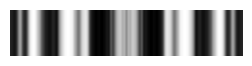


--- Iter 39 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2
Current FOM: 0.7895077503855124
Binary degree : 0.5164872378559785 


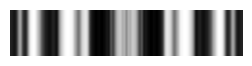


--- Iter 40 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2
Current FOM: 0.8892344178468092
Binary degree : 0.5187814429947892 


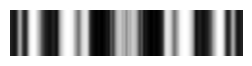


--- Iter 41 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2
Current FOM: 0.8258617611445862
Binary degree : 0.5213418643361608 


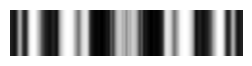


--- Iter 42 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2
Current FOM: 0.8614304930556219
Binary degree : 0.5239786806760212 


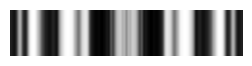


--- Iter 43 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2
Current FOM: 0.8859791611783617
Binary degree : 0.526653555887456 


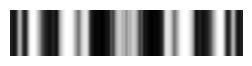


--- Iter 44 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2
Current FOM: 0.8843683972534642
Binary degree : 0.5292328810219704 


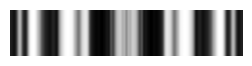


--- Iter 45 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2
Current FOM: 0.9064686458572909
Binary degree : 0.5324980263917961 


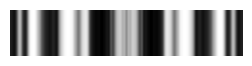


--- Iter 46 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2
Current FOM: 0.8878320672624552
Binary degree : 0.5359934908371305 


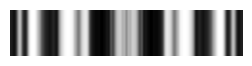


--- Iter 47 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2
Current FOM: 0.9385182796074529
Binary degree : 0.5392739732357013 


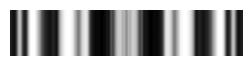


--- Iter 48 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2
Current FOM: 0.9049749179454508
Binary degree : 0.5423978190910309 


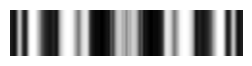


--- Iter 49 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2
Current FOM: 0.9477567025777346
Binary degree : 0.5453399716169081 


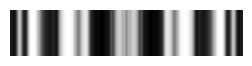


--- Iter 50 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2
Current FOM: 0.9187187899453026
Binary degree : 0.5479949813350279 


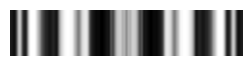


--- Iter 51 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2
Current FOM: 0.9547673612339351
Binary degree : 0.5504266379930609 


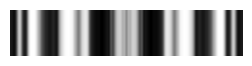


--- Iter 52 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2
Current FOM: 0.9379495133528172
Binary degree : 0.5526650329768846 


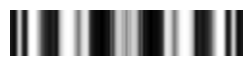


--- Iter 53 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2
Current FOM: 0.9683106294534224
Binary degree : 0.5548684401135687 


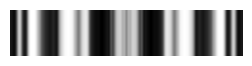


--- Iter 54 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2
Current FOM: 0.9496449440238535
Binary degree : 0.5569432514111554 


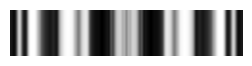


--- Iter 55 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2
Current FOM: 0.9738190481938812
Binary degree : 0.558847926749938 


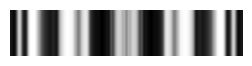


--- Iter 56 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2
Current FOM: 0.9536891693491224
Binary degree : 0.5606457697534222 


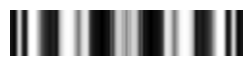


--- Iter 57 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2
Current FOM: 0.9812779338885925
Binary degree : 0.5625066257117655 


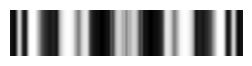


--- Iter 58 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2
Current FOM: 0.970394935759801
Binary degree : 0.5642368146805771 


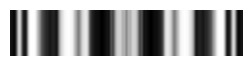


--- Iter 59 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2
Current FOM: 0.987285224876669
Binary degree : 0.5657716799877519 


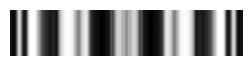


--- Iter 60 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2
Current FOM: 0.9825290154183719
Binary degree : 0.5672677385892874 


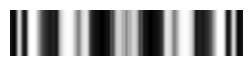


--- Iter 61 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2
Current FOM: 0.9893867329007934
Binary degree : 0.5687742716972922 


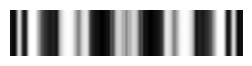


--- Iter 62 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2
Current FOM: 0.9990706216332169
Binary degree : 0.5701026545358182 


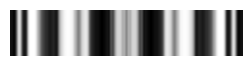


--- Iter 63 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2
Current FOM: 0.9904097612660508
Binary degree : 0.5712752479698207 


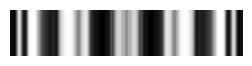


--- Iter 64 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2
Current FOM: 1.0086963931395667
Binary degree : 0.5724861374740459 


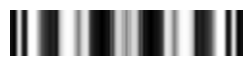


--- Iter 65 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2
Current FOM: 1.0063397360134307
Binary degree : 0.573656126733184 


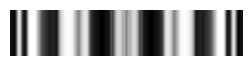


--- Iter 66 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2
Current FOM: 1.0105179241718514
Binary degree : 0.5747565719208659 


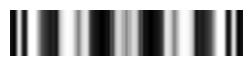


--- Iter 67 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2
Current FOM: 1.0194500348660502
Binary degree : 0.5759544888725862 


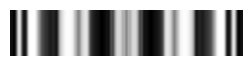


--- Iter 68 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2
Current FOM: 1.0173478390161812
Binary degree : 0.5771037514752455 


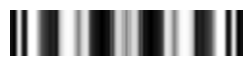


--- Iter 69 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2
Current FOM: 1.024240274215838
Binary degree : 0.5781068984260278 


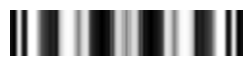


--- Iter 70 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2
Current FOM: 1.0260769060747799
Binary degree : 0.5790818725600203 


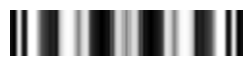


--- Iter 71 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2
Current FOM: 1.0272074268479912
Binary degree : 0.5800854613502565 


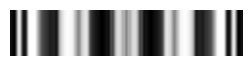


--- Iter 72 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.119991000809926
Current FOM: 1.0335770910973954
Binary degree : 0.5808310459779215 


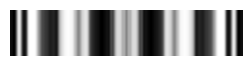


--- Iter 73 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.119991000809926
Current FOM: 0.9857761215749296
Binary degree : 0.5890373467052017 


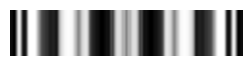


--- Iter 74 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.119991000809926
Current FOM: 0.9182502125280495
Binary degree : 0.589884334879063 


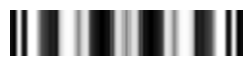


--- Iter 75 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.119991000809926
Current FOM: 1.0057832652772607
Binary degree : 0.5904628407338505 


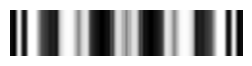


--- Iter 76 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.119991000809926
Current FOM: 0.877625321219873
Binary degree : 0.5907935527699748 


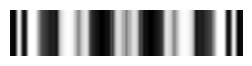


--- Iter 77 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.119991000809926
Current FOM: 1.0283127406985368
Binary degree : 0.5916179296560752 


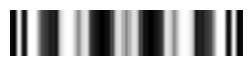


--- Iter 78 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.119991000809926
Current FOM: 0.9518580853340717
Binary degree : 0.5926872396158196 


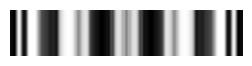


--- Iter 79 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.119991000809926
Current FOM: 1.0441356815325573
Binary degree : 0.5932201335719921 


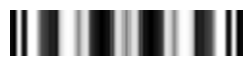


--- Iter 80 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.119991000809926
Current FOM: 0.9834141364406289
Binary degree : 0.5936785350308292 


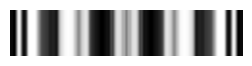


--- Iter 81 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.119991000809926
Current FOM: 1.0080987195533688
Binary degree : 0.5946166548802676 


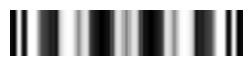


--- Iter 82 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.119991000809926
Current FOM: 1.0114959978684948
Binary degree : 0.5950938869949512 


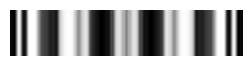


--- Iter 83 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.119991000809926
Current FOM: 1.014212009002277
Binary degree : 0.5951290486067419 


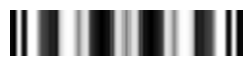


--- Iter 84 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.249578944845655
Current FOM: 1.0561336820472564
Binary degree : 0.595792461273125 


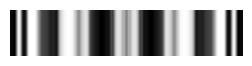


--- Iter 85 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.249578944845655
Current FOM: 1.0396464845672495
Binary degree : 0.6043895475215433 


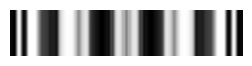


--- Iter 86 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.249578944845655
Current FOM: 1.0018381263126008
Binary degree : 0.6048302768210512 


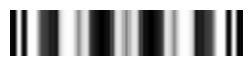


--- Iter 87 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.249578944845655
Current FOM: 1.0538192764468537
Binary degree : 0.6051191988573703 


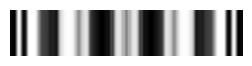


--- Iter 88 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.249578944845655
Current FOM: 1.0242765397615612
Binary degree : 0.6052701384253637 


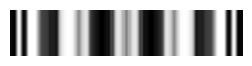


--- Iter 89 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.249578944845655
Current FOM: 1.046373649573145
Binary degree : 0.6054114909712589 


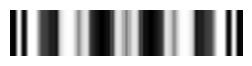


--- Iter 90 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.249578944845655
Current FOM: 1.047888461478977
Binary degree : 0.6054854109485519 


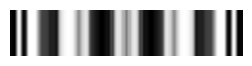


--- Iter 91 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.249578944845655
Current FOM: 1.0343519373170889
Binary degree : 0.6056610196390128 


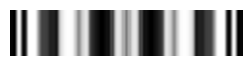


--- Iter 92 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.249578944845655
Current FOM: 1.066603284599101
Binary degree : 0.6056778782234228 


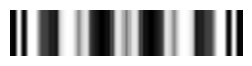


--- Iter 93 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.249578944845655
Current FOM: 1.0472542857846434
Binary degree : 0.6056221838862791 


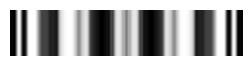


--- Iter 94 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.249578944845655
Current FOM: 1.0665225628456536
Binary degree : 0.6056527472333628 


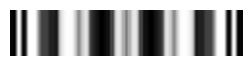


--- Iter 95 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.249578944845655
Current FOM: 1.0646653421582486
Binary degree : 0.60562707141061 


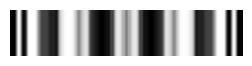


--- Iter 96 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.249578944845655
Current FOM: 1.0601756331050733
Binary degree : 0.6055747691063005 


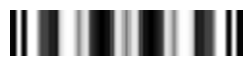


--- Iter 97 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.3895309808284177
Current FOM: 1.0768086634595226
Binary degree : 0.6056377167875661 


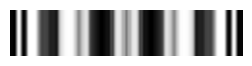


--- Iter 98 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.3895309808284177
Current FOM: 0.9332605438401111
Binary degree : 0.6141568609084487 


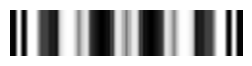


--- Iter 99 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.3895309808284177
Current FOM: 0.9137676670939674
Binary degree : 0.6141788329078388 


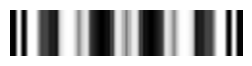


--- Iter 100 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.3895309808284177
Current FOM: 0.9105769472713113
Binary degree : 0.6144464371982448 


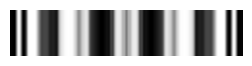


--- Iter 101 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.3895309808284177
Current FOM: 1.0350929474237975
Binary degree : 0.6149253940003904 


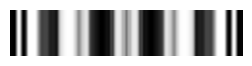


--- Iter 102 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.3895309808284177
Current FOM: 1.006783565620578
Binary degree : 0.615199835357561 


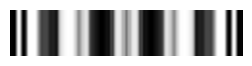


--- Iter 103 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.3895309808284177
Current FOM: 0.9867671823684792
Binary degree : 0.6152401884149165 


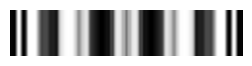


--- Iter 104 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.3895309808284177
Current FOM: 0.9899206981297056
Binary degree : 0.6154829916049886 


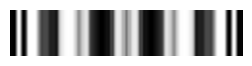


--- Iter 105 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.3895309808284177
Current FOM: 1.0405065892503322
Binary degree : 0.6158680578886687 


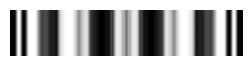


--- Iter 106 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.3895309808284177
Current FOM: 1.0509052435551647
Binary degree : 0.6159909942735861 


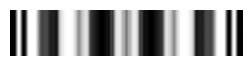


--- Iter 107 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.3895309808284177
Current FOM: 1.0190761504106638
Binary degree : 0.6158429688843194 


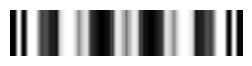


--- Iter 108 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.3895309808284177
Current FOM: 1.0468438868097865
Binary degree : 0.6158804892052757 


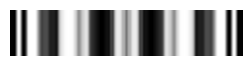


--- Iter 109 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.3895309808284177
Current FOM: 1.0430117248178292
Binary degree : 0.6159786343663317 


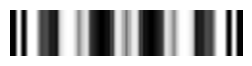


--- Iter 110 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.3895309808284177
Current FOM: 1.09354682291355
Binary degree : 0.615951506175812 


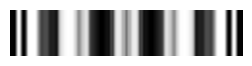


--- Iter 111 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.3895309808284177
Current FOM: 1.0458559518201171
Binary degree : 0.6158219758748041 


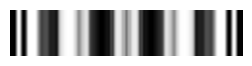


--- Iter 112 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.3895309808284177
Current FOM: 1.0945314718147061
Binary degree : 0.6158115811245747 


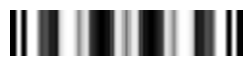


--- Iter 113 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.3895309808284177
Current FOM: 1.0314133382788961
Binary degree : 0.6158108454178102 


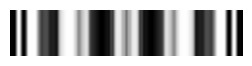


--- Iter 114 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.3895309808284177
Current FOM: 1.1002902592887558
Binary degree : 0.6158097523332677 


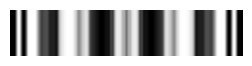


--- Iter 115 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.3895309808284177
Current FOM: 1.0678940530748613
Binary degree : 0.6158102033635966 


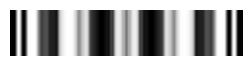


--- Iter 116 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.3895309808284177
Current FOM: 1.0981563564905665
Binary degree : 0.6160523794926015 


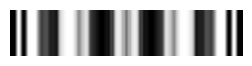


--- Iter 117 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.3895309808284177
Current FOM: 1.0846967275938888
Binary degree : 0.6162229198522683 


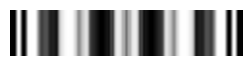


--- Iter 118 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.3895309808284177
Current FOM: 1.0849257392108629
Binary degree : 0.6160673415677183 


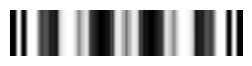


--- Iter 119 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.3895309808284177
Current FOM: 1.1054338333831175
Binary degree : 0.6162658183501036 


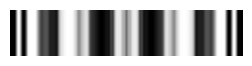


--- Iter 120 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.3895309808284177
Current FOM: 1.0675588139446843
Binary degree : 0.6166003118490472 


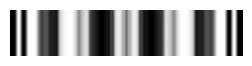


--- Iter 121 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.3895309808284177
Current FOM: 1.108610631159358
Binary degree : 0.6164861937352157 


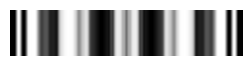


--- Iter 122 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.3895309808284177
Current FOM: 1.0981769440226943
Binary degree : 0.6165283081938318 


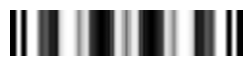


--- Iter 123 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.3895309808284177
Current FOM: 1.0986147184520527
Binary degree : 0.6168424631145325 


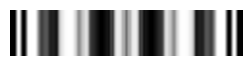


--- Iter 124 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.3895309808284177
Current FOM: 1.1154714780972668
Binary degree : 0.6168752919981009 


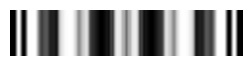


--- Iter 125 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.3895309808284177
Current FOM: 1.105023865143089
Binary degree : 0.6168091852242079 


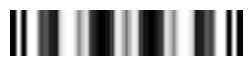


--- Iter 126 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.3895309808284177
Current FOM: 1.1189912718338422
Binary degree : 0.6170035616219959 


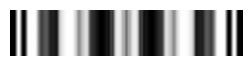


--- Iter 127 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.3895309808284177
Current FOM: 1.1061082442920311
Binary degree : 0.6171369207580201 


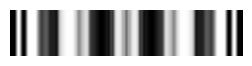


--- Iter 128 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.3895309808284177
Current FOM: 1.1134119307467103
Binary degree : 0.6170742992253005 


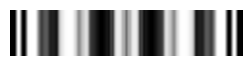


--- Iter 129 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.3895309808284177
Current FOM: 1.1212894823239736
Binary degree : 0.6172098603702671 


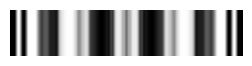


--- Iter 130 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.3895309808284177
Current FOM: 1.103882992936395
Binary degree : 0.6174164953936198 


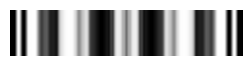


--- Iter 131 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.3895309808284177
Current FOM: 1.121274006065925
Binary degree : 0.617409339087041 


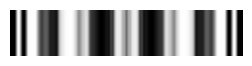


--- Iter 132 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.3895309808284177
Current FOM: 1.122064235308695
Binary degree : 0.617554762583772 


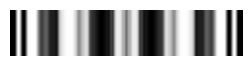


--- Iter 133 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.3895309808284177
Current FOM: 1.110434603122139
Binary degree : 0.617839341429629 


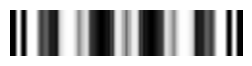


--- Iter 134 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.3895309808284177
Current FOM: 1.1256149702359708
Binary degree : 0.6179272792324464 


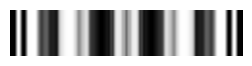


--- Iter 135 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.3895309808284177
Current FOM: 1.1239832661068074
Binary degree : 0.6181070476262681 


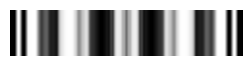


--- Iter 136 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.3895309808284177
Current FOM: 1.1164878102044984
Binary degree : 0.618427490321 


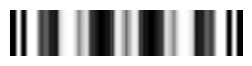


--- Iter 137 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.3895309808284177
Current FOM: 1.1273890365061927
Binary degree : 0.61858382853486 


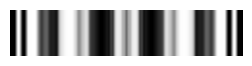


--- Iter 138 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.3895309808284177
Current FOM: 1.1265495022593197
Binary degree : 0.6188038638289897 


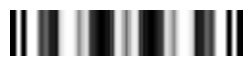


--- Iter 139 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.3895309808284177
Current FOM: 1.1208829570614942
Binary degree : 0.6191432006122165 


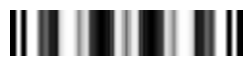


--- Iter 140 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.3895309808284177
Current FOM: 1.1291169423146101
Binary degree : 0.6193542090164934 


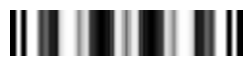


--- Iter 141 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.3895309808284177
Current FOM: 1.1292238993157135
Binary degree : 0.6196275880263651 


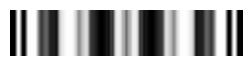


--- Iter 142 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.3895309808284177
Current FOM: 1.1242223064110772
Binary degree : 0.6199938732745485 


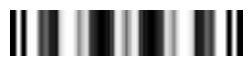


--- Iter 143 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.5406754718792666
Current FOM: 1.1308518207380645
Binary degree : 0.6202591857108619 


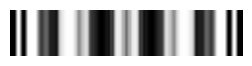


--- Iter 144 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.5406754718792666
Current FOM: 1.0544943583840265
Binary degree : 0.6295129155884069 


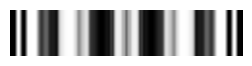


--- Iter 145 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.5406754718792666
Current FOM: 0.9608031766733268
Binary degree : 0.6291464176436447 


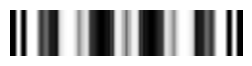


--- Iter 146 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.5406754718792666
Current FOM: 1.02697399961542
Binary degree : 0.6296494636137978 


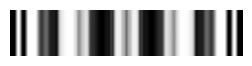


--- Iter 147 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.5406754718792666
Current FOM: 0.9751041612331868
Binary degree : 0.6307697181921823 


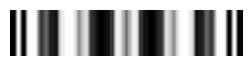


--- Iter 148 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.5406754718792666
Current FOM: 1.1324315120801978
Binary degree : 0.6309005663591126 


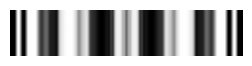


--- Iter 149 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.5406754718792666
Current FOM: 1.0215401542994464
Binary degree : 0.6308863486912624 


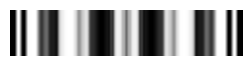


--- Iter 150 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.5406754718792666
Current FOM: 1.1291615552064647
Binary degree : 0.6316489391243086 


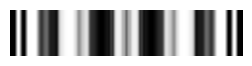


--- Iter 151 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.5406754718792666
Current FOM: 1.0013975827850183
Binary degree : 0.6324372405962032 


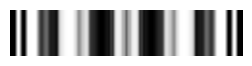


--- Iter 152 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.5406754718792666
Current FOM: 1.1046950405269318
Binary degree : 0.6322356442322031 


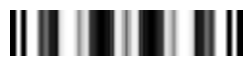


--- Iter 153 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.5406754718792666
Current FOM: 1.0636641593065372
Binary degree : 0.6324686054770082 


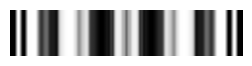


--- Iter 154 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.5406754718792666
Current FOM: 1.1118651296170574
Binary degree : 0.6333073353475149 


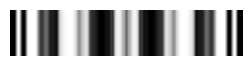


--- Iter 155 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.5406754718792666
Current FOM: 1.1132795303186926
Binary degree : 0.6335915815504944 


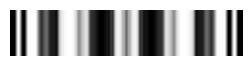


--- Iter 156 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.5406754718792666
Current FOM: 1.0877526986923511
Binary degree : 0.6333658564460902 


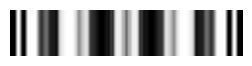


--- Iter 157 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.5406754718792666
Current FOM: 1.1292123528129945
Binary degree : 0.6337026549094166 


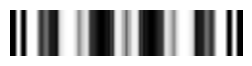


--- Iter 158 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.5406754718792666
Current FOM: 1.0626426721212496
Binary degree : 0.6342084694340999 


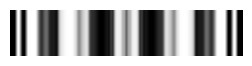


--- Iter 159 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.5406754718792666
Current FOM: 1.1344724693754142
Binary degree : 0.6340218832323097 


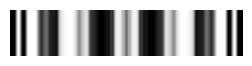


--- Iter 160 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.5406754718792666
Current FOM: 1.107512312808315
Binary degree : 0.6340101221931076 


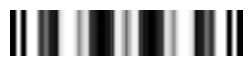


--- Iter 161 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.5406754718792666
Current FOM: 1.1214359313047946
Binary degree : 0.6344176298014013 


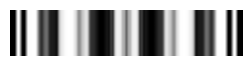


--- Iter 162 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.5406754718792666
Current FOM: 1.1321863861707313
Binary degree : 0.6344176591141079 


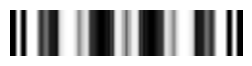


--- Iter 163 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.5406754718792666
Current FOM: 1.1169908133664617
Binary degree : 0.634137889985694 


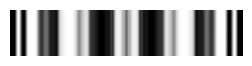


--- Iter 164 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.5406754718792666
Current FOM: 1.1436755142208188
Binary degree : 0.6342805710366347 


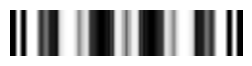


--- Iter 165 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.5406754718792666
Current FOM: 1.1061229032904447
Binary degree : 0.6344075235849863 


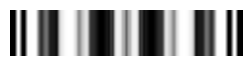


--- Iter 166 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.5406754718792666
Current FOM: 1.1307701104596493
Binary degree : 0.6340447375823532 


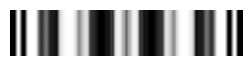


--- Iter 167 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.5406754718792666
Current FOM: 1.138171090992852
Binary degree : 0.6340265837490615 


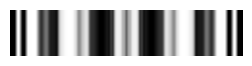


--- Iter 168 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.5406754718792666
Current FOM: 1.1088081206864677
Binary degree : 0.6342141871465772 


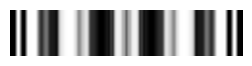


--- Iter 169 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.5406754718792666
Current FOM: 1.1439215954367983
Binary degree : 0.6339276102722559 


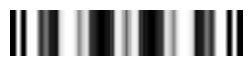


--- Iter 170 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.5406754718792666
Current FOM: 1.1370947722249418
Binary degree : 0.6338115620435361 


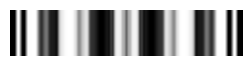


--- Iter 171 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.5406754718792666
Current FOM: 1.1291717898378444
Binary degree : 0.6339708431968556 


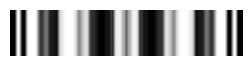


--- Iter 172 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.5406754718792666
Current FOM: 1.1478859369366639
Binary degree : 0.6338022951116834 


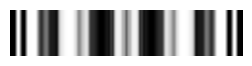


--- Iter 173 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.5406754718792666
Current FOM: 1.1400342931014837
Binary degree : 0.6336257608632213 


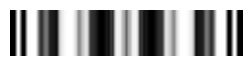


--- Iter 174 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.5406754718792666
Current FOM: 1.1431945617238508
Binary degree : 0.633724145330013 


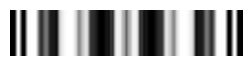


--- Iter 175 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.5406754718792666
Current FOM: 1.1442280288035307
Binary degree : 0.6336622814846214 


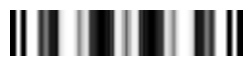


--- Iter 176 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.7039068518040135
Current FOM: 1.143113413891539
Binary degree : 0.6334736417394564 


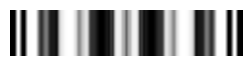


--- Iter 177 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.7039068518040135
Current FOM: 1.0168270022037431
Binary degree : 0.6428949672241969 


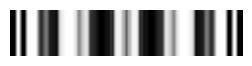


--- Iter 178 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.7039068518040135
Current FOM: 0.9893260271312252
Binary degree : 0.6419282894343599 


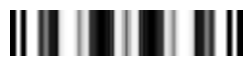


--- Iter 179 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.7039068518040135
Current FOM: 0.9810346776867284
Binary degree : 0.6419458359374961 


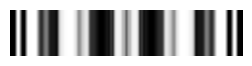


--- Iter 180 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.7039068518040135
Current FOM: 1.0947944625401373
Binary degree : 0.6428663681315222 


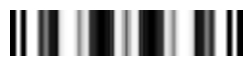


--- Iter 181 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.7039068518040135
Current FOM: 1.0766035829633842
Binary degree : 0.6429473018176748 


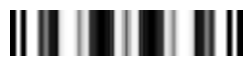


--- Iter 182 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.7039068518040135
Current FOM: 1.0344611706529743
Binary degree : 0.6421327965619508 


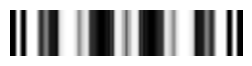


--- Iter 183 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.7039068518040135
Current FOM: 1.0655756547218436
Binary degree : 0.6422768159222967 


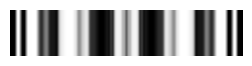


--- Iter 184 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.7039068518040135
Current FOM: 1.0523497813673817
Binary degree : 0.643137010965676 


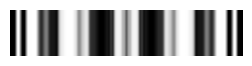


--- Iter 185 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.7039068518040135
Current FOM: 1.1412892798996386
Binary degree : 0.6429717930973562 


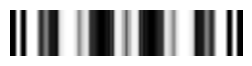


--- Iter 186 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.7039068518040135
Current FOM: 1.0623511236115872
Binary degree : 0.6426494916816283 


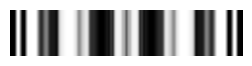


--- Iter 187 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.7039068518040135
Current FOM: 1.1418761073159176
Binary degree : 0.6428951161184121 


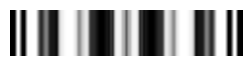


--- Iter 188 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.7039068518040135
Current FOM: 1.0423143572162787
Binary degree : 0.6432682965860715 


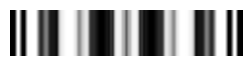


--- Iter 189 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.7039068518040135
Current FOM: 1.1430467268550983
Binary degree : 0.6430488077332739 


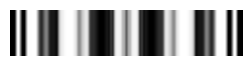


--- Iter 190 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.7039068518040135
Current FOM: 1.0988159724087614
Binary degree : 0.643027384828456 


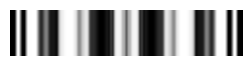


--- Iter 191 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.7039068518040135
Current FOM: 1.1383220906422975
Binary degree : 0.6433044545581104 


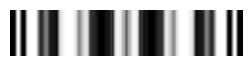


--- Iter 192 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.7039068518040135
Current FOM: 1.1238620975032731
Binary degree : 0.6433666365442758 


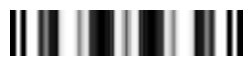


--- Iter 193 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.7039068518040135
Current FOM: 1.118305765156765
Binary degree : 0.6431872836599614 


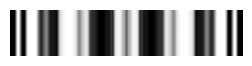


--- Iter 194 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.7039068518040135
Current FOM: 1.145773754998214
Binary degree : 0.6432712577306782 


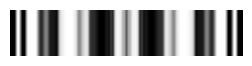


--- Iter 195 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.7039068518040135
Current FOM: 1.094560105995526
Binary degree : 0.6434282372802216 


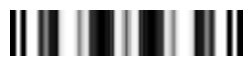


--- Iter 196 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.7039068518040135
Current FOM: 1.153445953791414
Binary degree : 0.6433044900629845 


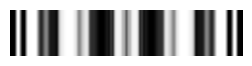


--- Iter 197 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.7039068518040135
Current FOM: 1.132048292792656
Binary degree : 0.6432347084542328 


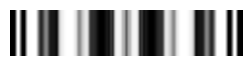


--- Iter 198 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.7039068518040135
Current FOM: 1.1414616617525783
Binary degree : 0.6433804706354794 


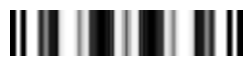


--- Iter 199 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.7039068518040135
Current FOM: 1.1483968703689096
Binary degree : 0.6433462865030928 


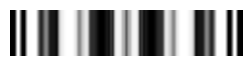


--- Iter 200 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.7039068518040135
Current FOM: 1.1390320648993972
Binary degree : 0.6431511674209686 


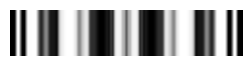


--- Iter 201 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.7039068518040135
Current FOM: 1.1583043649183902
Binary degree : 0.6431701804676108 


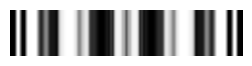


--- Iter 202 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.7039068518040135
Current FOM: 1.129928832344678
Binary degree : 0.6431662097197255 


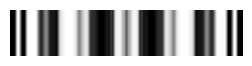


--- Iter 203 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.7039068518040135
Current FOM: 1.1517418041746792
Binary degree : 0.6429580452200997 


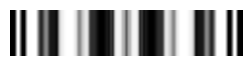


--- Iter 204 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.7039068518040135
Current FOM: 1.1545408043469503
Binary degree : 0.642882678660426 


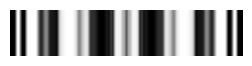


--- Iter 205 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.7039068518040135
Current FOM: 1.1357442436567282
Binary degree : 0.6428904877732485 


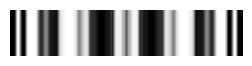


--- Iter 206 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.7039068518040135
Current FOM: 1.160113593467734
Binary degree : 0.6427301818367303 


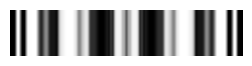


--- Iter 207 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.7039068518040135
Current FOM: 1.1527939997280372
Binary degree : 0.6425975745729748 


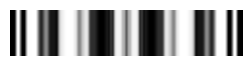


--- Iter 208 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.7039068518040135
Current FOM: 1.1510506354139307
Binary degree : 0.6425913939407198 


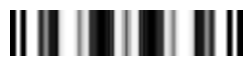


--- Iter 209 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.7039068518040135
Current FOM: 1.1579785427845453
Binary degree : 0.6424865129646795 


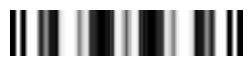


--- Iter 210 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.7039068518040135
Current FOM: 1.1546581543698917
Binary degree : 0.6423359435650657 


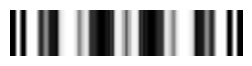


--- Iter 211 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.7039068518040135
Current FOM: 1.159102391780095
Binary degree : 0.6423148494805812 


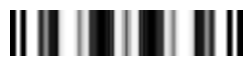


--- Iter 212 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.8801908592846712
Current FOM: 1.1526927443944055
Binary degree : 0.6422817590996126 


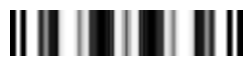


--- Iter 213 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.8801908592846712
Current FOM: 1.0546638855541184
Binary degree : 0.6520145618978156 


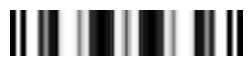


--- Iter 214 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.8801908592846712
Current FOM: 0.8982005502281283
Binary degree : 0.6519316442508638 


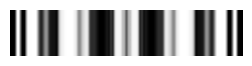


--- Iter 215 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.8801908592846712
Current FOM: 0.8611175558282107
Binary degree : 0.6520763526912446 


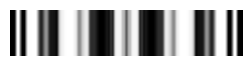


--- Iter 216 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.8801908592846712
Current FOM: 1.1526449592167687
Binary degree : 0.6524385417278383 


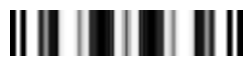


--- Iter 217 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.8801908592846712
Current FOM: 0.8657083902454494
Binary degree : 0.652600959068656 


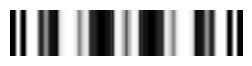


--- Iter 218 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.8801908592846712
Current FOM: 1.112722960259136
Binary degree : 0.6529253227328559 


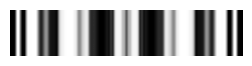


--- Iter 219 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.8801908592846712
Current FOM: 0.965072922868739
Binary degree : 0.6532041278152407 


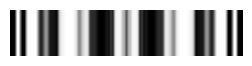


--- Iter 220 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.8801908592846712
Current FOM: 1.1536736278499515
Binary degree : 0.6536924446928355 


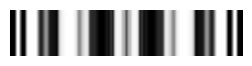


--- Iter 221 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.8801908592846712
Current FOM: 0.9545616172566213
Binary degree : 0.653983043405144 


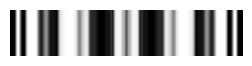


--- Iter 222 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.8801908592846712
Current FOM: 1.149701501572171
Binary degree : 0.6542489355153525 


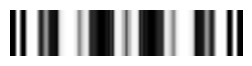


--- Iter 223 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.8801908592846712
Current FOM: 1.0275680190279701
Binary degree : 0.6543844066956508 


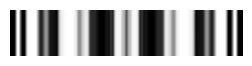


--- Iter 224 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.8801908592846712
Current FOM: 1.1576977370223
Binary degree : 0.6546626919291405 


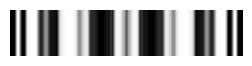


--- Iter 225 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.8801908592846712
Current FOM: 1.0256927665331568
Binary degree : 0.6547719931400917 


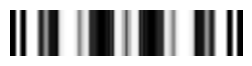


--- Iter 226 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.8801908592846712
Current FOM: 1.1597735449027031
Binary degree : 0.6548701755303489 


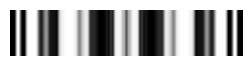


--- Iter 227 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.8801908592846712
Current FOM: 1.076521301349485
Binary degree : 0.6548353061157312 


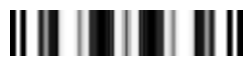


--- Iter 228 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.8801908592846712
Current FOM: 1.1660838070770636
Binary degree : 0.654885932053224 


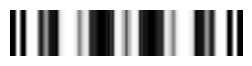


--- Iter 229 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.8801908592846712
Current FOM: 1.073728999668884
Binary degree : 0.6548059703940899 


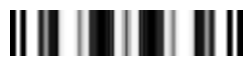


--- Iter 230 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.8801908592846712
Current FOM: 1.1545181335417833
Binary degree : 0.654743671050591 


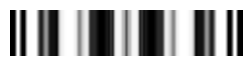


--- Iter 231 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.8801908592846712
Current FOM: 1.1147923942621183
Binary degree : 0.6546151126700298 


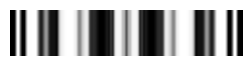


--- Iter 232 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.8801908592846712
Current FOM: 1.1557388079543969
Binary degree : 0.6545216404238657 


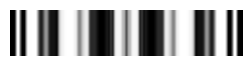


--- Iter 233 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.8801908592846712
Current FOM: 1.1306462749701907
Binary degree : 0.654353255694083 


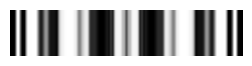


--- Iter 234 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.8801908592846712
Current FOM: 1.1391288689089611
Binary degree : 0.6541467729440197 


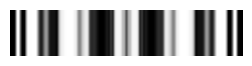


--- Iter 235 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.8801908592846712
Current FOM: 1.1530435529420686
Binary degree : 0.6539596248628743 


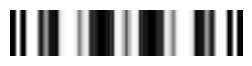


--- Iter 236 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.8801908592846712
Current FOM: 1.119959569839956
Binary degree : 0.6537716663974896 


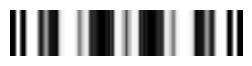


--- Iter 237 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.8801908592846712
Current FOM: 1.1682855289587444
Binary degree : 0.6535421878025038 


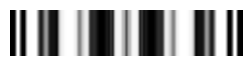


--- Iter 238 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.8801908592846712
Current FOM: 1.1421043969810227
Binary degree : 0.6532763118658682 


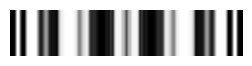


--- Iter 239 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.8801908592846712
Current FOM: 1.1670310125767027
Binary degree : 0.6531314724225606 


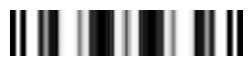


--- Iter 240 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.8801908592846712
Current FOM: 1.1422531892017769
Binary degree : 0.6529827931573952 


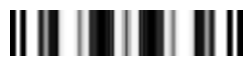


--- Iter 241 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.8801908592846712
Current FOM: 1.1588816236027022
Binary degree : 0.6525758632006223 


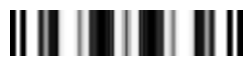


--- Iter 242 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.8801908592846712
Current FOM: 1.1645545311331524
Binary degree : 0.6523491431876927 


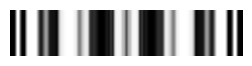


--- Iter 243 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.8801908592846712
Current FOM: 1.1436881850356244
Binary degree : 0.6522272388486794 


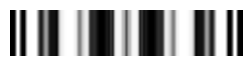


--- Iter 244 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.8801908592846712
Current FOM: 1.171132457581963
Binary degree : 0.6518602301052654 


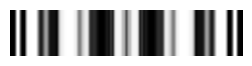


--- Iter 245 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.8801908592846712
Current FOM: 1.1594194033280854
Binary degree : 0.6514825448373966 


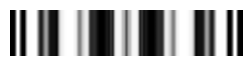


--- Iter 246 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.8801908592846712
Current FOM: 1.1668374211944714
Binary degree : 0.6512823391082223 


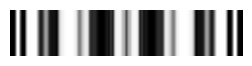


--- Iter 247 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.8801908592846712
Current FOM: 1.1611072234006243
Binary degree : 0.6509713245193955 


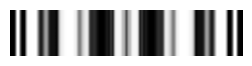


--- Iter 248 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.8801908592846712
Current FOM: 1.164610930930224
Binary degree : 0.6505135495438269 


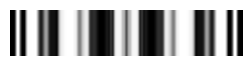


--- Iter 249 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 3.070570177466077
Current FOM: 1.1711195073441598
Binary degree : 0.6502070565360917 


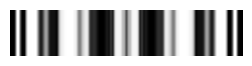


--- Iter 250 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 3.070570177466077
Current FOM: 0.8806325727175446
Binary degree : 0.6603508242212723 


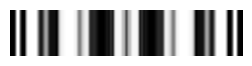


--- Iter 251 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 3.070570177466077
Current FOM: 0.9867019825195666
Binary degree : 0.6596046525358197 


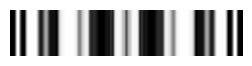


--- Iter 252 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 3.070570177466077
Current FOM: 0.8079636457152132
Binary degree : 0.6595322061800302 


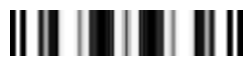


--- Iter 253 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 3.070570177466077
Current FOM: 1.0927808098057925
Binary degree : 0.6598084251143038 


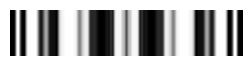


--- Iter 254 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 3.070570177466077
Current FOM: 0.8471899540318841
Binary degree : 0.6600305858240748 


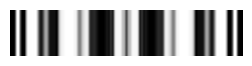


--- Iter 255 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 3.070570177466077
Current FOM: 1.1190202348448746
Binary degree : 0.6603067513043955 


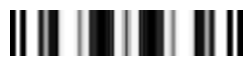


--- Iter 256 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 3.070570177466077
Current FOM: 0.9136420304858534
Binary degree : 0.6602325992740715 


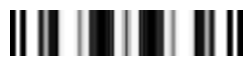


--- Iter 257 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 3.070570177466077
Current FOM: 0.8700422299128968
Binary degree : 0.6605009369538514 


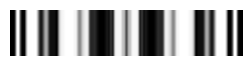


--- Iter 258 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 3.070570177466077
Current FOM: 1.15662229480789
Binary degree : 0.6608992153082758 


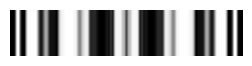


--- Iter 259 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 3.070570177466077
Current FOM: 0.8693158297879376
Binary degree : 0.6610464970333193 


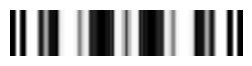


--- Iter 260 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 3.070570177466077
Current FOM: 1.1564105807435758
Binary degree : 0.661193136689154 


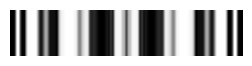


--- Iter 261 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 3.070570177466077
Current FOM: 0.9569465630962937
Binary degree : 0.6610623620320182 


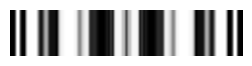


--- Iter 262 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 3.070570177466077
Current FOM: 1.0001477961144756
Binary degree : 0.6610149888565408 


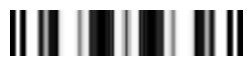


--- Iter 263 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 3.070570177466077
Current FOM: 1.1417630240785863
Binary degree : 0.6610980636461548 


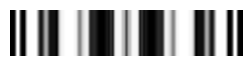


--- Iter 264 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 3.070570177466077
Current FOM: 1.0252819307623684
Binary degree : 0.660903654612364 


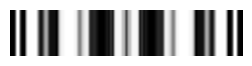


--- Iter 265 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 3.070570177466077
Current FOM: 1.1425887923121005
Binary degree : 0.6606163621085149 


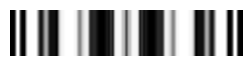


--- Iter 266 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 3.070570177466077
Current FOM: 1.0448291655758857
Binary degree : 0.6602407810048115 


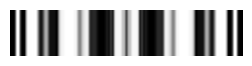


--- Iter 267 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 3.070570177466077
Current FOM: 1.1715357968404947
Binary degree : 0.6599230686093898 


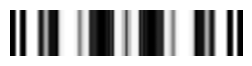


--- Iter 268 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 3.070570177466077
Current FOM: 1.051444681252829
Binary degree : 0.6594453035134733 


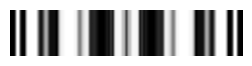


--- Iter 269 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 3.070570177466077
Current FOM: 1.1778704943300369
Binary degree : 0.6591736710482649 


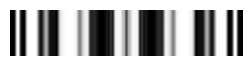


--- Iter 270 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 3.070570177466077
Current FOM: 1.092360170178978
Binary degree : 0.6590399036033903 


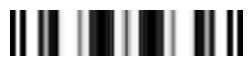


--- Iter 271 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 3.070570177466077
Current FOM: 1.170685590563742
Binary degree : 0.6586411924904327 


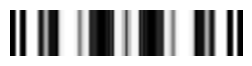


--- Iter 272 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 3.070570177466077
Current FOM: 1.087973125249829
Binary degree : 0.658164177386089 


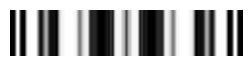


--- Iter 273 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 3.070570177466077
Current FOM: 1.1802584275880754
Binary degree : 0.658078961997494 


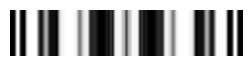


--- Iter 274 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 3.070570177466077
Current FOM: 1.1211332095140198
Binary degree : 0.6580024430555542 


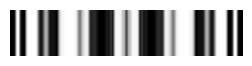


--- Iter 275 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 3.070570177466077
Current FOM: 1.1791317913365977
Binary degree : 0.657908871136729 


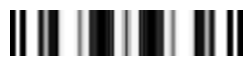


--- Iter 276 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 3.070570177466077
Current FOM: 1.108960805333487
Binary degree : 0.657851928768364 


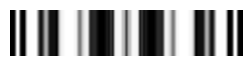


--- Iter 277 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 3.070570177466077
Current FOM: 1.179110243943877
Binary degree : 0.657867381255911 


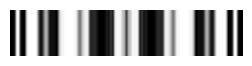


--- Iter 278 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 3.070570177466077
Current FOM: 1.143927199690947
Binary degree : 0.6578707176586388 


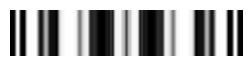


--- Iter 279 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 3.070570177466077
Current FOM: 1.1786895110132996
Binary degree : 0.6579206261793489 


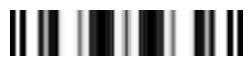


--- Iter 280 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 3.070570177466077
Current FOM: 1.144454136338491
Binary degree : 0.6580089814899243 


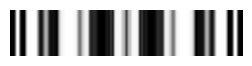


--- Iter 281 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 3.070570177466077
Current FOM: 1.1730639830629672
Binary degree : 0.6580466041498512 


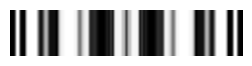


--- Iter 282 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 3.070570177466077
Current FOM: 1.1681427321730327
Binary degree : 0.6581286753852813 


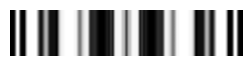


--- Iter 283 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 3.070570177466077
Current FOM: 1.1655015681143006
Binary degree : 0.658321781358382 


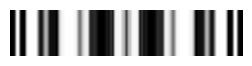


--- Iter 284 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 3.2761705079166803
Current FOM: 1.1764363435172422
Binary degree : 0.658405601709546 


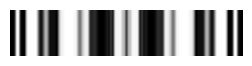


--- Iter 285 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 3.2761705079166803
Current FOM: 1.0539793207846546
Binary degree : 0.6696127222427306 


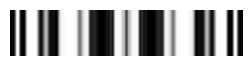


--- Iter 286 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 3.2761705079166803
Current FOM: 0.9512410065557984
Binary degree : 0.6694853716364134 


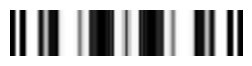


--- Iter 287 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 3.2761705079166803
Current FOM: 0.8382196000321581
Binary degree : 0.6695284525916951 


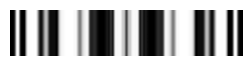


--- Iter 288 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 3.2761705079166803
Current FOM: 1.131292207507834
Binary degree : 0.6698373974210299 


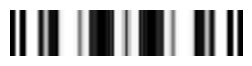


--- Iter 289 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 3.2761705079166803
Current FOM: 0.8719679106268963
Binary degree : 0.6700102103606297 


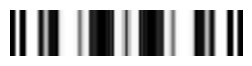


--- Iter 290 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 3.2761705079166803
Current FOM: 1.1319510327145608
Binary degree : 0.6701533602169085 


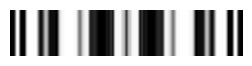


--- Iter 291 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 3.2761705079166803
Current FOM: 0.9470519892649376
Binary degree : 0.6699496201874326 


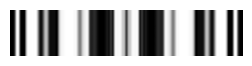


--- Iter 292 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 3.2761705079166803
Current FOM: 0.8973850273660503
Binary degree : 0.6699591164122165 


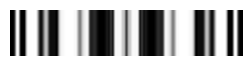


--- Iter 293 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 3.2761705079166803
Current FOM: 1.171870912265344
Binary degree : 0.6702165521867375 


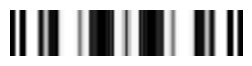


--- Iter 294 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 3.2761705079166803
Current FOM: 0.8981876498601779
Binary degree : 0.6702415652096323 


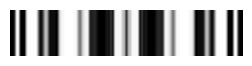


--- Iter 295 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 3.2761705079166803
Current FOM: 1.1702337955085145
Binary degree : 0.6703858332320952 


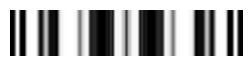


--- Iter 296 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 3.2761705079166803
Current FOM: 0.9857337531098206
Binary degree : 0.6704104996898305 


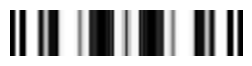


--- Iter 297 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 3.2761705079166803
Current FOM: 1.022259782119444
Binary degree : 0.6713308613257994 


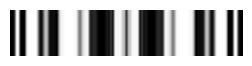


--- Iter 298 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 3.2761705079166803
Current FOM: 1.161948767605903
Binary degree : 0.672945231863397 


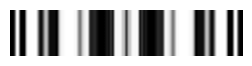


--- Iter 299 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 3.2761705079166803
Current FOM: 1.0384205830737625
Binary degree : 0.6739926363118606 


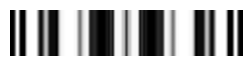


--- Iter 300 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 3.2761705079166803
Current FOM: 1.1671341029943505
Binary degree : 0.674112701946913 


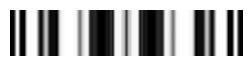

In [61]:
n = Nx * layer_num
np.random.seed(3)           
x = 0.4 + 0.2 * np.random.rand(n)  

cur_beta = 2

cur_iter             = [0]
evaluation_history   = []
beta_history         = []
binarization_history = []

g_histories   = [[] for _ in range(layer_num)]
x_histories   = [[] for _ in range(layer_num)]
lr_histories  = [[] for _ in range(layer_num)]
uf_histories  = [[] for _ in range(layer_num)]
t_histories   = [[] for _ in range(layer_num)]

optimizers = [AdamOptimizer(lr=0.02, beta1=0.9) for _ in range(layer_num)]

def f_multi(v, eta, beta):
    print(f"\n--- Iter {cur_iter[0]+1} ---")

    rho_full = multi_mapping(v, eta, beta)

    bin_deg = np.sum(np.abs(rho_full - 0.5)) / (0.5 * rho_full.size)
    binarization_history.append(bin_deg)

    size_each = Nx*Ny
    rho_list = [rho_full[i*size_each:(i+1)*size_each]
                for i in range(layer_num)]

    f0, dJ_du = opt(rho_list,
                    need_value=True,
                    need_gradient=True,
                    beta=beta)
    
    if not isinstance(dJ_du, (list, tuple)):
        dJ_du = [dJ_du]

    dJ_flat = np.concatenate([np.array(d).flatten() for d in dJ_du])

    gradient_full = tensor_jacobian_product(multi_mapping, 0)(
        v, eta_i, beta, dJ_flat
    )

    grad_list = [gradient_full[i*size_each:(i+1)*size_each]
                 for i in range(layer_num)]
    
    vs = v.reshape(layer_num, size_each)
    v_new_layers = []
    for i in range(layer_num):
        vi_new, lr, uf, m, vt, t = optimizers[i].update(vs[i], grad_list[i])
        lr_histories[i].append(lr)
        uf_histories[i].append(uf)
        t_histories[i].append(t)
        g_histories[i].append(grad_list[i].copy())
        x_histories[i].append(vi_new.copy())
        v_new_layers.append(vi_new)

    v_new = np.concatenate(v_new_layers)

    f_val = float(np.real(f0))

    beta_new = beta 

    if len(evaluation_history) >= 3:
        f_prev2 = evaluation_history[-3]
        f_prev1 = evaluation_history[-2]
        f_curr  = evaluation_history[-1]

        bin_prev2 = binarization_history[-3]
        bin_prev1 = binarization_history[-2]
        bin_curr  = binarization_history[-1]

        change1 = abs(f_curr  - f_prev1) / (abs(f_prev1) + 1e-12)
        change2 = abs(f_prev1 - f_prev2) / (abs(f_prev2) + 1e-12)

        bin_change1 = abs(bin_curr  - bin_prev1) / (abs(bin_prev1) + 1e-12)
        bin_change2 = abs(bin_prev1 - bin_prev2) / (abs(bin_prev2) + 1e-12)

        # 조건: FOM 변화율 + 이진화 변화율이 모두 작을 때
        if (change1 < 0.005 and change2 < 0.005) and (bin_change1 < 0.002 and bin_change2 < 0.002):
            beta_new = beta + 10*np.tanh((beta - 0.5)*0.01)


    evaluation_history.append(f_val)
    beta_history.append(beta_new)
    cur_iter[0] += 1

    print("Current beta: {}".format(beta_new))
    print("Current FOM: {}".format(f0))
    print("Binary degree : {} ".format(bin_deg))

    plt.figure(figsize=(3,2))
    ax = plt.gca()
    opt.plot2D(
        False,
        output_plane=mp.Volume(
            size=mp.Vector3(design_region_width,region_height_each*layer_num-1/resolution,0),
            center=mp.Vector3(0, full_center_y,0)
        ),
        ax=ax,
        show_sources=False,
        show_monitors=False,
        show_boundary_layers=False,
    )
    ax.axis("off")
    plt.show()

    return v_new, beta_new

mp.verbosity(0)
Max_iter = 300

while cur_iter[0] < Max_iter:
    x, cur_beta = f_multi(x, eta_i, cur_beta)
    if binarization_history[-1] > 0.98:
        print("Threshold reached → final mapping with β=∞")
        x, _ = f_multi(x, eta_i, np.inf)
        break

최대 FoM = 1.180258 는 iteration 273 에서 나왔습니다.


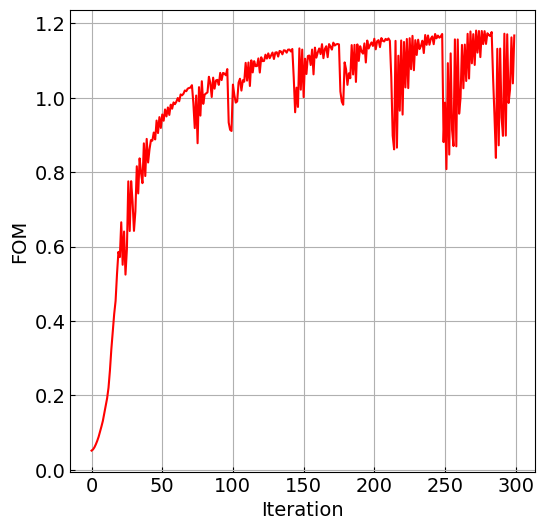

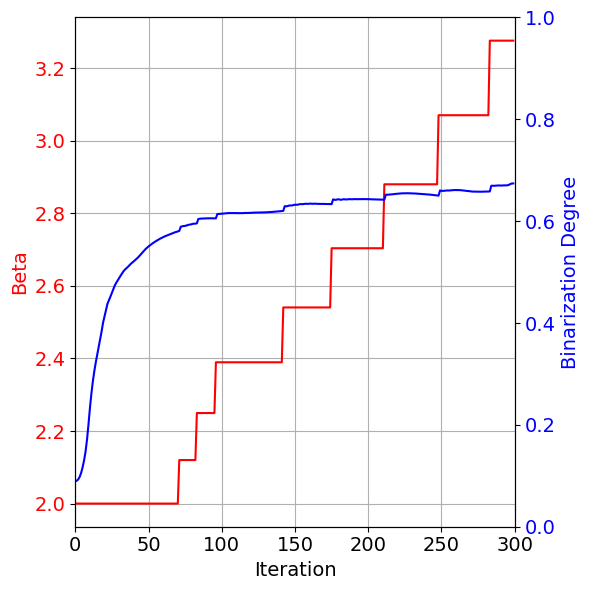

In [62]:
################ Find best FOM ################ 
eval_hist = np.array(evaluation_history)
max_val   = eval_hist.max()
max_idx0  = eval_hist.argmax()
iteration = max_idx0 + 1

print(f"최대 FoM = {max_val:.6f} 는 iteration {iteration} 에서 나왔습니다.")

################ FOM plot ################ 
plt.figure(figsize = (6,6))
plt.plot(evaluation_history, 'r-')
plt.xlabel('Iteration',fontsize = 14)
plt.ylabel('FOM',fontsize = 14)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.tick_params(direction = 'in')
plt.grid(True)
plt.show()

# ################ beta history plot ################ 
# plt.figure(figsize = (6,6))
# plt.plot(beta_history, 'g-')
# plt.xlabel('Iteration',fontsize = 14)
# plt.ylabel('Beta history',fontsize = 14)
# plt.xticks(fontsize = 14)
# plt.yticks(fontsize = 14)
# plt.xlim(0, np.array(cur_iter))
# plt.grid(True)
# plt.tick_params(direction = 'in')
# plt.show()

# ################ Binarization degree plot ################ 
# plt.figure(figsize = (6,6))
# plt.plot(binarization_history, 'b-')
# plt.xlabel('Iteration',fontsize = 14)
# plt.ylabel('Binarization degree',fontsize = 14)
# plt.xticks(fontsize = 14)
# plt.yticks(fontsize = 14)
# plt.xlim(0, np.array(cur_iter))
# plt.ylim(0,1)
# plt.grid(True)
# plt.tick_params(direction = 'in')
# plt.show()

################ Combined Beta and Binarization Degree Plot ################ 
fig, ax1 = plt.subplots(figsize=(6,6))

color1 = 'red'
ax1.set_xlabel('Iteration', fontsize=14)
ax1.set_ylabel('Beta', color=color1, fontsize=14)
ax1.plot(beta_history, color=color1, label='Beta History')
ax1.tick_params(axis='y', labelcolor=color1)
ax1.set_xlim(0, np.array(cur_iter))
ax1.tick_params(labelsize=14)
ax1.grid(True)

ax2 = ax1.twinx()
color2 = 'blue'
ax2.set_ylabel('Binarization Degree', color=color2, fontsize=14)
ax2.plot(binarization_history, color=color2, linestyle='-', label='Binarization Degree')
ax2.tick_params(axis='y', labelcolor=color2)
ax2.set_ylim(0.4, 1)
ax2.set_ylim(0, 1)
ax2.tick_params(labelsize=14)

fig.tight_layout()
# plt.title('Beta & Binarization Degree', fontsize=15)
plt.show()

(-1.2, 1.2, 1.26, 1.74)

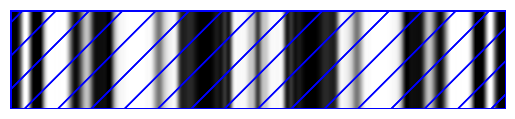

In [63]:
opt.plot2D(
    True,
    output_plane = mp.Volume(size = mp.Vector3(design_region_width, design_region_height-1/resolution, 0), center = mp.Vector3(0, full_center_y,0)),
    
    plot_sources_flag=False,
    plot_monitors_flag=False,
    plot_boundaries_flag=False,
)
plt.axis(False)

<Axes: xlabel='X', ylabel='Y'>

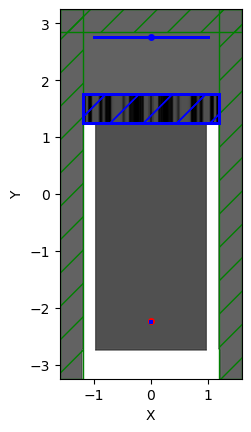

In [64]:
offset = 0.01
flux_size = 0.02
mn_size = 2

monitor_position_y, monitor_size = mp.Vector3(0, center_y_monitor_position), mp.Vector3(mn_size,0)

#### input source의 flux ####
input_flux = opt.sim.add_flux(
        fcen, 0, 1,
        mp.FluxRegion(center=sources.center - mp.Vector3(offset, 0, 0),
                    size=mp.Vector3(0, flux_size),
                    # direction=mp.X, 
                    weight=-1),
        mp.FluxRegion(center=sources.center + mp.Vector3(offset, 0, 0),
                    size=mp.Vector3(0, flux_size),
                    # direction=mp.X
                    ),
        mp.FluxRegion(center=sources.center - mp.Vector3(0, offset, 0),
                    size=mp.Vector3(flux_size, 0),
                    # direction=mp.Y, 
                    weight=-1),
        mp.FluxRegion(center=sources.center + mp.Vector3(0, offset, 0),
                    size=mp.Vector3(flux_size, 0),
                    # direction=mp.Y
                    )
    )

#### output flux -> add flux로 계산한 poynting vector ####
out_flux = opt.sim.add_flux(
        fcen, 0, 1,
        mp.FluxRegion(
                center=monitor_position_y,
                size=monitor_size,
                # direction=mp.Y
                # weight=-1
        )
    )

#### output flux -> 성분별 field를 뽑고, poynting vector를 계산할 예정 ####
dft_fields = opt.sim.add_dft_fields([mp.Ex, mp.Ey, mp.Ez, mp.Hx, mp.Hy, mp.Hz], fcen, 0, 1, 
                                    center = monitor_position_y,
                                    size = monitor_size, 
                                    yee_grid=True)

opt.sim.plot2D()


-----------
Initializing structure...
time for choose_chunkdivision = 3.8147e-05 s
Working in 2D dimensions.
Computational cell is 3.2 x 6.5 x 0 with resolution 50
     block, center = (0,-3,0)
          size (2.4,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-0.75,0)
          size (2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (-1.1,-0.75,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (1.1,-0.75,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,1.5,0)
          size (2.4,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
time for set_epsilon = 0.0602241 s
time for set_conductivity = 0.002033 s
time for set_conductiv

/home/min/miniconda3/envs/mp/lib/python3.9/site-packages/meep/visualization.py:284: UserWarning: The specified user volume is larger than the simulation domain and has been truncated.
  warnings.warn(


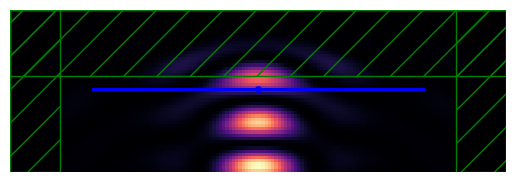

In [65]:
mp.verbosity(1)
sim.run(until_after_sources=mp.stop_when_fields_decayed(10/df, mp.Ez, sources.center, 1e-5))
# sim.run(until_after_sources=mp.stop_when_dft_decayed(1e-3))

opt.sim.plot2D(
    fields=mp.Ez,
    output_plane=mp.Volume(
    center = monitor_position_y,
    size = mp.Vector3(3, 1)),
    field_parameters={
        'post_process': lambda x: np.abs(np.real(x))**2,  # 복소수 필드 x → intensity |x|^2
        'cmap': 'magma',                         # 원하시는 colormap
        'alpha': 1,                            # 투명도
        'interpolation': 'none'
    },
    eps_parameters={'cmap':'magma','alpha':0.5}
)
plt.axis(False)
plt.show()

     block, center = (0,-3,0)
          size (2.4,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-0.75,0)
          size (2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (-1.1,-0.75,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (1.1,-0.75,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,1.5,0)
          size (2.4,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)


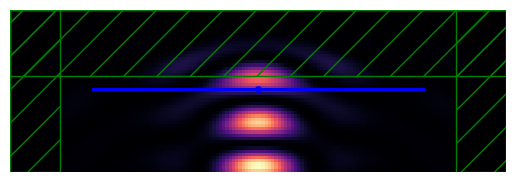

In [66]:
opt.sim.plot2D(
    fields=mp.Ez,
    output_plane=mp.Volume(
    center = monitor_position_y,
    size = mp.Vector3(3, 1)),
    field_parameters={
        'post_process': lambda x: np.abs(np.real(x))**2,  # 복소수 필드 x → intensity |x|^2
        'cmap': 'magma',                         # 원하시는 colormap
        'alpha': 1,                            # 투명도
        'interpolation': 'none'
    },
    eps_parameters={'cmap':'magma','alpha':0.5}
)
plt.axis(False)
plt.show()

     block, center = (0,-3,0)
          size (2.4,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-0.75,0)
          size (2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (-1.1,-0.75,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (1.1,-0.75,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,1.5,0)
          size (2.4,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)


<Axes: xlabel='X', ylabel='Y'>

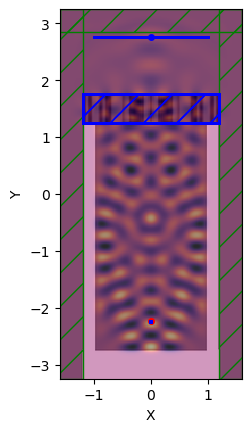

In [67]:
opt.sim.plot2D(fields = mp.Ez,
           field_parameters={
        'cmap': 'magma',    # magma 컬러맵 지정
        'alpha': 0.5,       # 필드 투명도 (0.0~1.0)
        'interpolation': 'none'
    }
)

In [ ]:
#### fwhM 3배

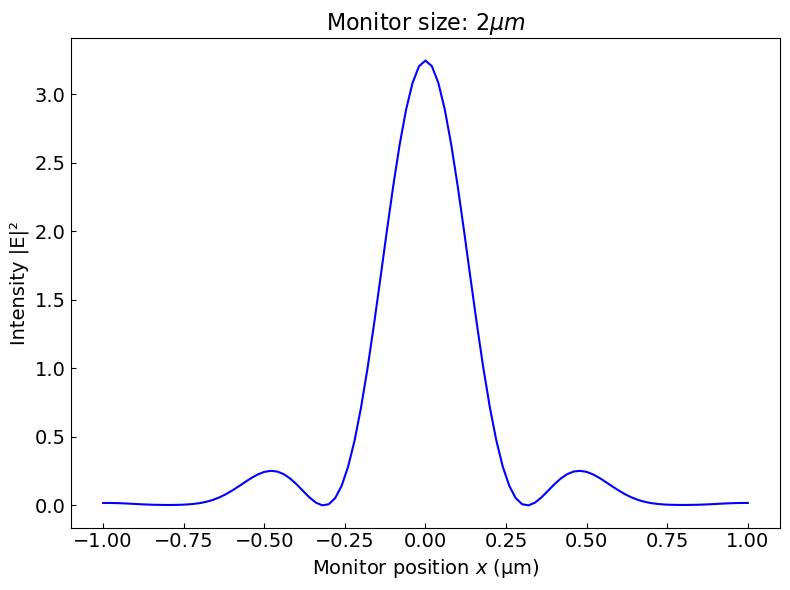

In [68]:
external_field_array = np.real(sim.get_dft_array(dft_fields, mp.Ez, 0))

N = len(external_field_array)
W = mn_size                           # μm 단위 모니터 폭
x = np.linspace(-W/2, W/2, N)                     # μm 단위 위치
z = abs(center_y_monitor_position - center_y_source_position)  # μm 단위 거리

# 3) Intensity 계산
I = np.abs(external_field_array)**2

# 4) θ 축으로 플롯
plt.figure(figsize=(8,6))
plt.plot(x, I, 'b-')


plt.xlabel('Monitor position $x$ (µm)', fontsize=14)
plt.ylabel('Intensity |E|²',       fontsize=14)
# plt.ylabel('phase',       fontsize=14)
plt.title(r'Monitor size: $2\mu m$', fontsize=16)
plt.tick_params(direction = 'in')
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.tight_layout()
plt.show()

In [69]:
eqe = mp.get_fluxes(out_flux)[0]/mp.get_fluxes(input_flux)[0]*100

print("Input flux :", mp.get_fluxes(input_flux)[0])
print("Output flux :", mp.get_fluxes(out_flux)[0])
print("EQE(%) :", eqe,"%")

Input flux : 1.1822712530110646
Output flux : 1.0492838055771412
EQE(%) : 88.751528289703 %


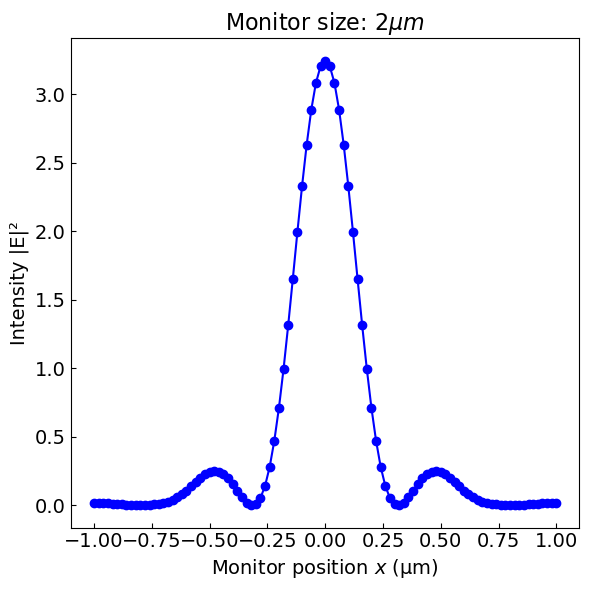

In [70]:
external_field_array = np.real(sim.get_dft_array(dft_fields, mp.Ez, 0))

N = len(external_field_array)
W = mn_size                           # μm 단위 모니터 폭
x = np.linspace(-W/2, W/2, N)                     # μm 단위 위치
z = abs(center_y_monitor_position - center_y_source_position)  # μm 단위 거리

# 3) Intensity 계산
I = np.abs(external_field_array)**2

# 4) θ 축으로 플롯
plt.figure(figsize=(6,6))
plt.plot(x, I, 'bo-')


plt.xlabel('Monitor position $x$ (µm)', fontsize=14)
plt.ylabel('Intensity |E|²',       fontsize=14)
# plt.ylabel('phase',       fontsize=14)
plt.title(r'Monitor size: $2\mu m$', fontsize=16)
plt.tick_params(direction = 'in')
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.tight_layout()
plt.show()

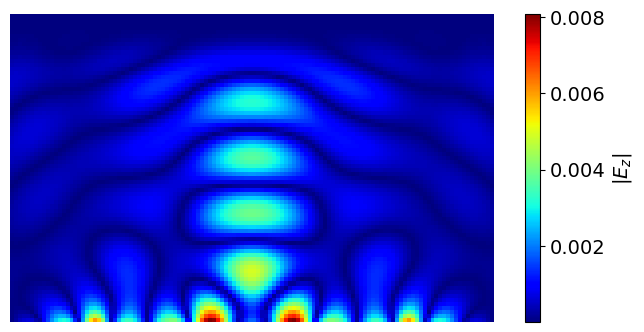

In [71]:
import numpy as np
import matplotlib.pyplot as plt
import meep as mp

nx = int(design_region_resolution * design_region_width) + 1
x_res = np.linspace(-design_region_width/2,
                     design_region_width/2,
                     nx)

y_start = center_y_design + design_region_height/2
y_end   = center_y_monitor_position + 1/fcen
ny = int(design_region_resolution * (y_end - y_start)) + 1
y_res = np.linspace(y_start, y_end, ny)

vol = mp.Volume(
    center=mp.Vector3(0, (y_start + y_end)/2, 0),
    size=  mp.Vector3(design_region_width,
                      y_end - y_start,
                      0)
)
Ez_slice = opt.sim.get_array(mp.Ez, vol).T   # shape == (ny, nx)

plt.figure(figsize=(8,4))
plt.imshow(
    np.abs(Ez_slice),      # (ny, nx)
    origin='lower',
    extent=[x_res.min(), x_res.max(), y_res.min(), y_res.max()],
    aspect='equal',
    cmap='jet'
)

cbar = plt.colorbar()
cbar.set_label(r'$|E_z|$', fontsize=14)
cbar.ax.tick_params(labelsize=14)

# plt.xlabel('Monitor position $x$ (µm)', fontsize=14)
# plt.ylabel('Height $y$ (µm)',           fontsize=14)
# plt.title(r'Monitor size: $2\ \mu m$',   fontsize=16)

# 틱 폰트 크기 및 방향 맞추기
plt.tick_params(direction='in', labelsize=14)
# plt.tight_layout()
plt.axis('off')
plt.show()

#### 소스 위치나 모니터 위치, 구조물 등등)

In [72]:
import numpy as np

I = np.real(external_field_array)**2
N = len(I)
W = mn_size
x = np.linspace(-W/2, W/2, N)
z = abs(center_y_monitor_position - center_y_source_position)

center_idx = np.argmax(I)
# 간단히 for문으로
for i in range(center_idx+1, N-1):
    if I[i] < I[i-1] and I[i] < I[i+1]:
        x_limit = abs(x[i])
        break
else:
    raise RuntimeError("1차 링 경계를 찾을 수 없음")

x_min, x_max = -x_limit, x_limit

mask = (x >= x_min) & (x <= x_max)

x_slice = x[mask]
I_slice = I[mask]

dx = x[1] - x[0]
flux_slice = np.sum(I_slice) * dx   

input = np.array(mp.get_fluxes(input_flux))[0]
output = np.array(mp.get_fluxes(out_flux))[0]

print("Input flux :", input)
print("Output flux :", output)
print(f"±{x_limit:.3f} µm 구간 integrated intensity: {flux_slice}")

optical_eqe = flux_slice/input * 100
print("1차 ring까지의 Optical EQE :", optical_eqe,"%")

Input flux : 1.1822712530110646
Output flux : 1.0492838055771412
±0.320 µm 구간 integrated intensity: 0.936081671747273
1차 ring까지의 Optical EQE : 79.1765569333785 %


In [26]:
import numpy as np

# 1) 강도 계산
I = np.abs(external_field_array)**2
N = len(I)
W = mn_size
x = np.linspace(-W/2, W/2, N)
center_idx = np.argmax(I)

# 2) 첫 번째 링 경계: 미분으로 valley 찾기
dI = np.diff(I)
valleys = np.where((dI[:-1] < 0) & (dI[1:] > 0))[0] + 1
valleys = valleys[valleys > center_idx]
if valleys.size == 0:
    raise RuntimeError("1차 링 경계를 찾을 수 없음")
idx_valley = valleys[0]
x_limit = abs(x[idx_valley])

# 3) 적분 구간 설정
mask = (x >= -x_limit) & (x <= x_limit)
dx = x[1] - x[0]
flux_slice = np.sum(I[mask]) * dx

# 4) Flux 모니터 값
input_flux  = np.array(mp.get_fluxes(input_flux))[0]
output_flux = np.array(mp.get_fluxes(out_flux))[0]

# 5) Optical EQE 계산: 출력 flux 비율을 사용
optical_eqe = output_flux / input_flux * 100

print(f"±{x_limit:.3f} µm 구간 intensity 적분: {flux_slice:.4f}")
print(f"모니터 기반 Optical EQE: {optical_eqe:.2f}%")


±0.320 µm 구간 intensity 적분: 1.0391
모니터 기반 Optical EQE: 75.64%


In [287]:
eqe = mp.get_fluxes(out_flux)[0]/mp.get_fluxes(input_flux)[0]*100
    
print("Input flux :", mp.get_fluxes(input_flux)[0])
print("Output flux :", mp.get_fluxes(out_flux)[0])
print("EQE(%) :", eqe,"%")

AttributeError: 'numpy.float64' object has no attribute 'flux'